In [7]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('NLPData/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('NLPData/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['NLPData\\Arabic.txt', 'NLPData\\Chinese.txt', 'NLPData\\Czech.txt', 'NLPData\\Dutch.txt', 'NLPData\\English.txt', 'NLPData\\French.txt', 'NLPData\\German.txt', 'NLPData\\Greek.txt', 'NLPData\\Irish.txt', 'NLPData\\Italian.txt', 'NLPData\\Japanese.txt', 'NLPData\\Korean.txt', 'NLPData\\Polish.txt', 'NLPData\\Portuguese.txt', 'NLPData\\Russian.txt', 'NLPData\\Scottish.txt', 'NLPData\\Spanish.txt', 'NLPData\\Vietnamese.txt']
Slusarski


In [8]:
print(category_lines['Spanish'][:5])

['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal']


In [9]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

#Turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [10]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [11]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [12]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8846, -2.9061, -2.8382, -2.9679, -2.7958, -2.9651, -2.8984, -2.8772,
         -3.0142, -2.9024, -2.8552, -2.9222, -2.9697, -2.8078, -2.9537, -2.8426,
         -2.8642, -2.7964]], grad_fn=<LogSoftmaxBackward0>)


In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 4)


In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Marlow
category = Polish / line = Pasternak
category = Dutch / line = Snyders
category = Greek / line = Chrysanthopoulos
category = English / line = Kennard
category = Czech / line = Korycansky
category = Korean / line = Han
category = Greek / line = Koustoubos
category = Czech / line = Duyava
category = Polish / line = Krol


In [15]:
criterion = nn.NLLLoss()

In [16]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [17]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.6304 Fearghal / Greek ✗ (Irish)
10000 10% (0m 12s) 1.9287 Okano / Japanese ✓
15000 15% (0m 18s) 1.1747 Thao / Chinese ✗ (Vietnamese)
20000 20% (0m 23s) 2.7030 Banderas / Greek ✗ (Spanish)
25000 25% (0m 29s) 0.5817 Dinh / Vietnamese ✓
30000 30% (0m 35s) 0.6416 Truong / Vietnamese ✓
35000 35% (0m 41s) 3.8614 Richelieu / Scottish ✗ (French)
40000 40% (0m 47s) 0.8496 Mui / Chinese ✓
45000 45% (0m 52s) 3.3271 Munro / Portuguese ✗ (Scottish)
50000 50% (0m 58s) 0.5708 Suh / Korean ✓
55000 55% (1m 3s) 2.9636 Basso / Arabic ✗ (Italian)
60000 60% (1m 8s) 1.4548 Morton / Irish ✗ (English)
65000 65% (1m 14s) 2.2517 Cruz / Spanish ✗ (Portuguese)
70000 70% (1m 19s) 3.6703 Pavlu / French ✗ (Czech)
75000 75% (1m 24s) 0.3617 Yamakawa / Japanese ✓
80000 80% (1m 30s) 0.4491 Weng / Chinese ✓
85000 85% (1m 35s) 1.7920 Aart / French ✗ (Dutch)
90000 90% (1m 41s) 0.8419 Wilchek / Czech ✓
95000 95% (1m 46s) 0.8911 Hermann / German ✓
100000 100% (1m 52s) 1.7837 Valerio / Portuguese ✗ (Italian)

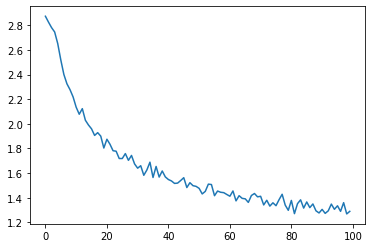

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\Anusha\AppData\Local\Temp/ipykernel_11260/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\Anusha\AppData\Local\Temp/ipykernel_11260/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


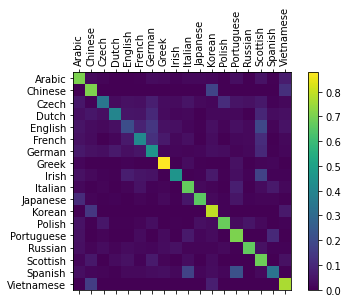

In [19]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [20]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.63) Czech
(-0.93) Russian
(-3.65) Polish

> Jackson
(-0.78) Scottish
(-1.46) English
(-2.24) Russian

> Satoshi
(-1.05) Arabic
(-1.43) Italian
(-1.74) Japanese
